In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib qt

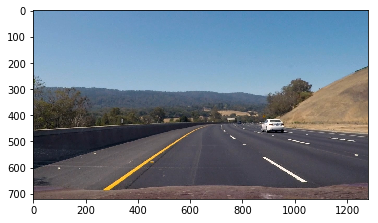

In [2]:
# Read in image names
images = glob.glob('test_images/*.jpg')
fileNum = 5
img_test = img = mpimg.imread(images[fileNum])
plt.imshow(img_test)

In [3]:
# Create binary image
def Binary_line_detection(img):
    
    
    # Define parameters
    sobel_kernel = 15
    thresh_sobel = [20,100]
    thresh_mag = [50, 255]
    thresh_dir = [0.7, 1.3]
    thresh_S = [170, 255]
    
    # convert RGB to HLS space and grab Saturation channel
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_Saturation = img[:,:,2]
    #imgS = cv2.GaussianBlur(img_Saturation, (5,5), 0) # Blur and denoise
    imgS = img_Saturation
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ## Line detection using sobel ##
    # There are serval things needed to know when using Sobel
    # 1) data type should be float
    # 2) results should be converted to absolute value
    # 3) finally, normalize results and scale to 255. This is to convert value to uint8
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # 1,0 means orient = x
    abs_sobelx = np.absolute(sobelx)
    abs_sobelx = np.uint8(abs_sobelx/np.amax(abs_sobelx)*255)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # 0,1 means orient = y
    abs_sobely = np.absolute(sobely)
    abs_sobely = np.uint8(abs_sobely/np.amax(abs_sobely)*255)
    binary_sobelx = np.zeros_like(imgS)
    binary_sobelx[(abs_sobelx >= thresh_sobel[0]) & (abs_sobelx <= thresh_sobel[1])] = 1
    binary_sobely = np.zeros_like(imgS)
    binary_sobely[(abs_sobely >= thresh_sobel[0]) & (abs_sobely <= thresh_sobel[1])] = 1
    
        
    ## Line detection using gradient magnitude ##
    sobely = cv2.Sobel(imgS, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # 0,1 means orient = y
    # To preserve the percision, do not directly use abs_sobelx
    abs_mag = np.sqrt(sobelx**2 + sobely**2)
    abs_mag = np.uint8(abs_mag/np.amax(abs_mag)*255)
    binary_mag = np.zeros_like(imgS)
    binary_mag[(abs_mag >= thresh_mag[0]) & (abs_mag <= thresh_mag[1])] = 1
    
    ## Line detection using angle ##
    dir_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_dir = np.zeros_like(imgS)
    binary_dir[(dir_sobel >= thresh_dir[0]) & (dir_sobel <= thresh_dir[1])] = 1
    
    ## Line detection using color thresholding ##
    binary_color = np.zeros_like(imgS)
    binary_color[(imgS >= thresh_S[0]) & (imgS <= thresh_S[1])] = 1
    
    ## Combine three method
    binary_combine = np.zeros_like(imgS)
    #binary_combine[( ((binary_sobelx == 1) & (binary_sobely == 1)) & ((binary_mag == 1) & (binary_dir == 1) ) ) | (binary_color == 1)] = 1
    #binary_combine[( ((binary_sobelx == 1) & (binary_sobely == 1)) | ((binary_mag == 1) & (binary_dir == 1) ) ) ] = 1
    binary_combine[(binary_sobelx == 1) | (binary_color == 1)] = 1
    #binary_combine[ ((binary_sobelx == 1) & (binary_dir == 1)) | (binary_color == 1)] = 1
    
    return binary_combine, imgS, binary_dir, binary_sobelx

In [4]:
test1, test2, b_dir, b_sobelx = Binary_line_detection(img_test)

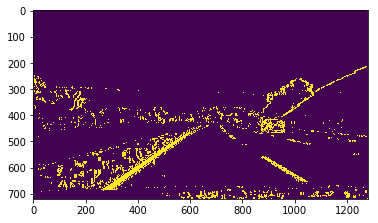

In [5]:
plt.imshow(test1)

In [6]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M

In [7]:
# src (source) contains the x,y coordinate
src = np.float32(
    [[490, 482], 
     [810, 482],  
     [1250, 720],  
     [40, 720]])   
# dst (distination)
dst = np.float32(
    [[0, 0], 
    [1280, 0], 
    [1250, 720],
    [40, 720]]) 

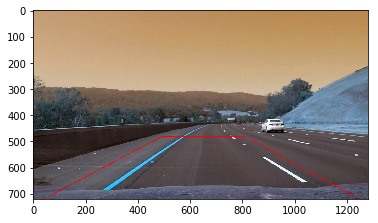

In [8]:
copy = cv2.imread(images[fileNum])
color = [255, 0, 0]
w = 2
cv2.line(copy, (src[0][0],src[0][1]), (src[1][0],src[1][1]), color, w)
cv2.line(copy, (src[1][0],src[1][1]), (src[2][0],src[2][1]), color, w)
cv2.line(copy, (src[3][0],src[3][1]), (src[2][0],src[2][1]), color, w)
cv2.line(copy, (src[3][0],src[3][1]), (src[0][0],src[0][1]), color, w)

plt.imshow(copy)

In [9]:
warped_img, M = warper(test1, src, dst)

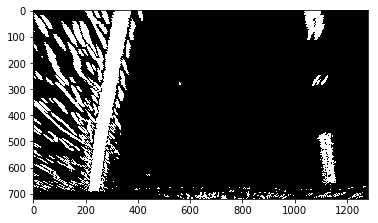

(1280,)

In [10]:
plt.imshow(warped_img, cmap='gray')
plt.show()
warped_img[0].shape

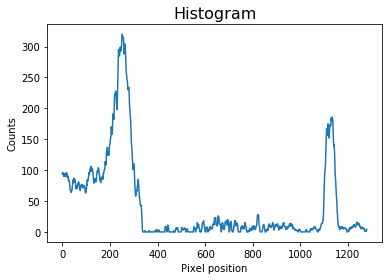

In [11]:
# Use half of the image, and compute the histogram
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

# Run de function over the combined warped image
histogram = get_histogram(warped_img)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

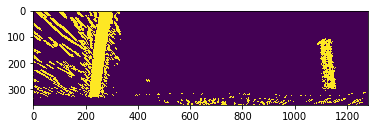

In [26]:
# An example of half image
plt.imshow(warped_img[warped_img.shape[0]//2:, :])

In [28]:
# Note: the codes below are revised based on https://github.com/juano2310/CarND-Advanced-Lane-Lines-Juan/blob/master/README.md
# I carefully studied the codes and made the adjustments based on the my own binary detection results.

Left and right points
Left:  [242.0, 241.0, 255.0, 266.0, 279.0, 293.0, 303.0, 319.0, 334.0]
Right:  [1129.0, 1129.0, 1120.0, 1114.0, 1014.0, 1093.0, 993.0, 1073.0, 1075.0]

Fitted image


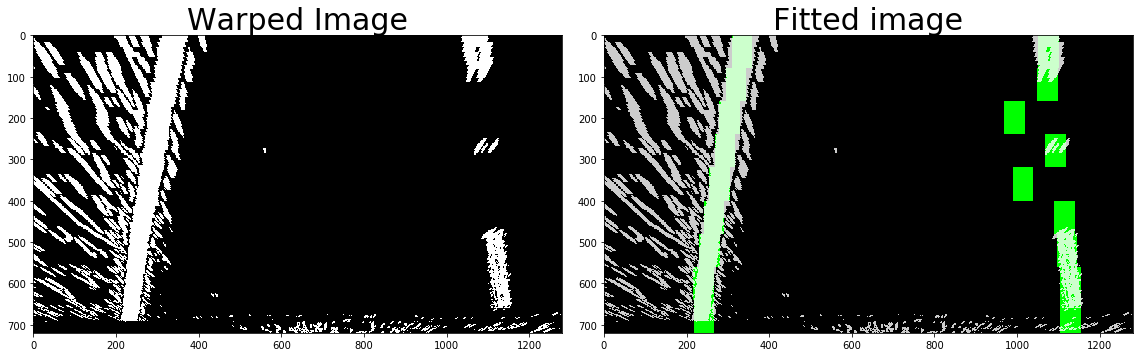

In [12]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    leftx = []
    rightx = []
    
    window = np.ones(window_width) # Create our window template that we will use for convolutions   
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))  
    leftx.append(l_center)
    rightx.append(r_center)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        prev_l_center = l_center        
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset      
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        prev_r_center = r_center
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        leftx.append(l_center)
        rightx.append(r_center)

    return window_centroids, leftx, rightx

window_centroids, leftx, rightx = find_window_centroids(warped_img, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped_img)
    r_points = np.zeros_like(warped_img)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped_img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped_img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    warpage = np.array(out_img,np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 0.8, template, 1, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped_img,warped_img,warped_img)),np.uint8)

# Display the final results
print('Left and right points')
print ('Left: ',leftx)
print ('Right: ',rightx)
print('')
print('Fitted image')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Warped Image", fontsize=30)
ax1.imshow(warped_img, cmap='gray')
ax2.set_title("Fitted image", fontsize=30)
ax2.imshow(output)

Left: 2446.99876382 m - Right: 507.416611659 m


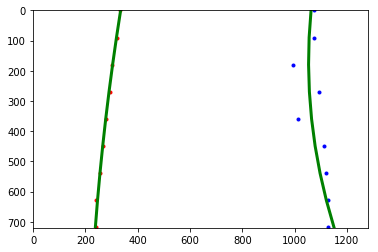

In [13]:
# to cover same y-range as image
ploty = np.linspace(0, 719, num=9)

def curvature(leftx, rightx):
    leftx = np.asarray(leftx[::-1])  # Reverse to match top-to-bottom in y
    rightx = np.asarray(rightx[::-1])  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    position = ((rightx_int+leftx_int)/2)-50
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad

position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad = curvature(leftx, rightx)

# Plot up the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Now our radius of curvature is in meters
print('Left:',left_curverad, 'm - Right:', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

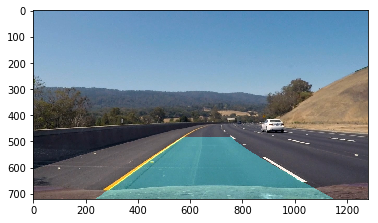

In [14]:
def warpBack(image, warp, persp_M, le_fitx, ri_fitx):
    Minv = np.linalg.inv(persp_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([le_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([ri_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

plt.imshow(warpBack(img_test, warped_img, M, left_fitx, right_fitx))

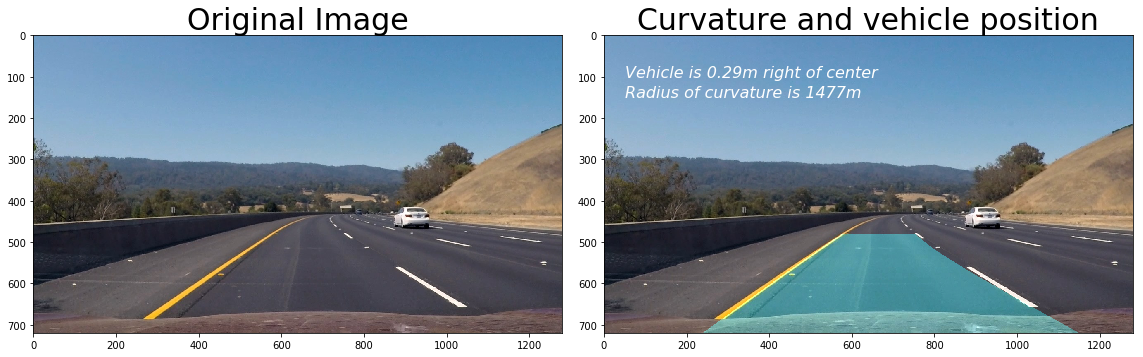

In [15]:
# Compare the original image and result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Curvature and vehicle position", fontsize=30)

if position == 640:
    ax2.text(50, 100, 'Vehicle is in the center', style='italic', color='white', fontsize=16)
elif position < 640:
    ax2.text(50, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)
else:
    ax2.text(50, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)

ax2.text(50, 150, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), 
         style='italic', color='white', fontsize=16)

ax2.imshow(warpBack(img_test, warped_img, M, left_fitx, right_fitx))


Test Final Pipeline


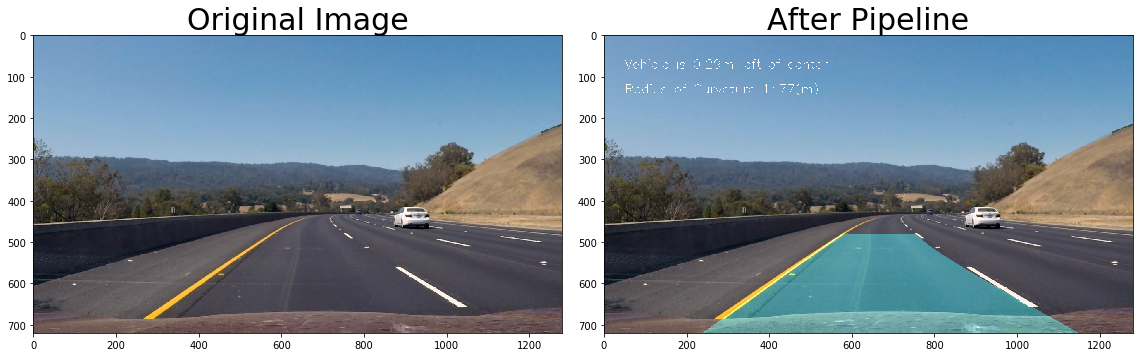

In [19]:
# Final pipeline verification
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
              
def final_pipeline(im):  
    undistorded = im # didn't undistrod yet
    final_binary, test2, b_dir, b_sobelx = Binary_line_detection(im)
    final_warped, final_perspective_M = warper(final_binary, src, dst)
    window_cent, lex, rix = find_window_centroids(final_warped, window_width, window_height, margin)      
    position, center, leftx, rightx, left_lane.recent_xfitted, right_lane.recent_xfitted, left_lane.radius_of_curvature, right_lane.radius_of_curvature = curvature(lex, rix)

    alpha = 0.5
    if left_lane.bestx == None:
        left_lane.bestx = left_lane.recent_xfitted
    else :    
        left_lane.recent_xfitted = left_lane.recent_xfitted * ( 1 - alpha) + alpha * left_lane.bestx
        
    if right_lane.bestx == None:
        right_lane.bestx = right_lane.recent_xfitted
    else :    
        right_lane.recent_xfitted = right_lane.recent_xfitted * ( 1 - alpha) + alpha * right_lane.bestx  
            
    #Sanity check  
    left_lane.detected = False
    right_lane.detected = False 
    
    max_distance = 0  
    min_distance = 10000
    for i in range(len(left_lane.recent_xfitted)) : 
        point_distance = right_lane.recent_xfitted[i] - left_lane.recent_xfitted[i]
        if point_distance > max_distance:
            max_distance = point_distance
        if point_distance < min_distance:
            min_distance = point_distance    
        
    if (min_distance > 710) and (max_distance < 900):
        left_lane.detected = True
        right_lane.detected = True              
        
    if not left_lane.detected:
        left_lane.recent_xfitted = left_lane.bestx
    else:
        left_lane.bestx = left_lane.recent_xfitted
    if not right_lane.detected:
        right_lane.recent_xfitted = right_lane.bestx
    else:
        right_lane.bestx = right_lane.recent_xfitted
    
    result = warpBack(im, final_warped, final_perspective_M, left_lane.recent_xfitted, right_lane.recent_xfitted)    
    
    # Print distance from center on video
    if (center*3.7/700) < 0.01:
        cv2.putText(result, 'Vehicle is in the center', (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    elif center < 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2)), (50,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    
    return result

# Test Final Pipeline
print('Test Final Pipeline')
left_lane = Line()
right_lane = Line()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("After Pipeline", fontsize=30)
ax2.imshow(final_pipeline(img_test))

In [20]:
# Create video results
# Using Project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lane = Line()
right_lane = Line()
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(38,43)
white_clip = clip1.fl_image(final_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [06:58<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 3min 45s, sys: 1min 2s, total: 4min 48s
Wall time: 7min 1s


In [27]:
# Create video results
# Using challenge video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lane = Line()
right_lane = Line()
white_output = 'challenge_video_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(38,43)
white_clip = clip1.fl_image(final_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video challenge_video_result.mp4
[MoviePy] Writing video challenge_video_result.mp4


100%|██████████| 485/485 [02:38<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_result.mp4 

CPU times: user 1min 26s, sys: 24.5 s, total: 1min 51s
Wall time: 2min 41s
